In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
# prices = pd.read_csv('round2/prices_round_2_day_0.csv', sep=';')
# trades = pd.read_csv('round2/trades_round_2_day_0_nn.csv', sep=';')
prices = pd.concat([pd.read_csv(f'round2/prices_round_2_day_{i}.csv', sep=';') for i in range(-1, 2)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round2/trades_round_2_day_{i}_nn.csv', sep=';') for i in range(-1, 2)], ignore_index=True)

In [3]:
prices['swmid'] = (prices['bid_price_1'] * prices['ask_volume_1'] + prices['ask_price_1'] * prices['bid_volume_1']) / (prices['ask_volume_1'] + prices['bid_volume_1'])

In [4]:
croissants = prices[prices["product"] == "CROISSANTS"].reset_index(drop=True).copy()
jams = prices[prices["product"] == "JAMS"].reset_index(drop=True).copy()
djembes = prices[prices["product"] == "DJEMBES"].reset_index(drop=True).copy()
basket1 = prices[prices["product"] == 'PICNIC_BASKET1'].reset_index(drop=True).copy()
basket2 = prices[prices["product"] == 'PICNIC_BASKET2'].reset_index(drop=True).copy()

In [5]:
[croissants, jams, djembes, basket1, basket2] = [df.drop(columns=['product']) for df in [croissants, jams, djembes, basket1, basket2]]

In [6]:
croissants = croissants.rename(columns={col: col + '_croissants' for col in croissants.columns if col not in ['timestamp', 'day']})
jams = jams.rename(columns={col: col + '_jams' for col in jams.columns if col not in ['timestamp', 'day']})
djembes = djembes.rename(columns={col: col + '_djembes' for col in djembes.columns if col not in ['timestamp', 'day']})
basket1 = basket1.rename(columns={col: col + '_basket1' for col in basket1.columns if col not in ['timestamp', 'day']})
basket2 = basket2.rename(columns={col: col + '_basket2' for col in basket2.columns if col not in ['timestamp', 'day']})

`PICNIC_BASKET1` contains three products: 

1. Six (6) `CROISSANTS`
2. Three (3) `JAMS`
3. One (1) `DJEMBE`

`PICNIC_BASKET2` contains just two products: 

1. Four (4) `CROISSANTS`
2. Two (2) `JAMS`

Aside from the Picnic Baskets, you can now also trade the three products individually on the island exchange. 

Position limits for the newly introduced products:

- `CROISSANT`: 250
- `JAM`: 350
- `DJEMBE`: 60
- `PICNIC_BASKET1`: 60
- `PICNIC_BASKET2`: 100

In [7]:
# join croissants, james, djembes, basket1, basket2 on timestamp
mk = croissants.merge(jams, on=['day', 'timestamp'])
mk = mk.merge(djembes, on=['day', 'timestamp'])
mk = mk.merge(basket1, on=['day', 'timestamp'])
mk = mk.merge(basket2, on=['day', 'timestamp'])
mk

,day,timestamp,bid_price_1_croissants,bid_volume_1_croissants,bid_price_2_croissants,bid_volume_2_croissants,bid_price_3_croissants,bid_volume_3_croissants,ask_price_1_croissants,ask_volume_1_croissants,...,bid_volume_3_basket2,ask_price_1_basket2,ask_volume_1_basket2,ask_price_2_basket2,ask_volume_2_basket2,ask_price_3_basket2,ask_volume_3_basket2,mid_price_basket2,profit_and_loss_basket2,swmid_basket2
0,-1,0,4304,112,NaN,NaN,NaN,NaN,4305,112,...,NaN,30612,20,30613.0,18.0,NaN,NaN,30609.0,0.0,30609.000000
1,-1,100,4304,133,NaN,NaN,NaN,NaN,4305,133,...,NaN,30616,37,NaN,NaN,NaN,NaN,30613.0,0.0,30611.888889
2,-1,200,4304,110,NaN,NaN,NaN,NaN,4305,110,...,NaN,30618,33,NaN,NaN,NaN,NaN,30615.0,0.0,30613.695652
3,-1,300,4304,118,NaN,NaN,NaN,NaN,4305,118,...,NaN,30623,19,30624.0,24.0,NaN,NaN,30620.5,0.0,30618.476190
4,-1,400,4305,142,NaN,NaN,NaN,NaN,4306,142,...,NaN,30622,6,30625.0,17.0,30626.0,28.0,30621.0,0.0,30620.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,999500,4268,120,NaN,NaN,NaN,NaN,4269,120,...,NaN,30120,1,30121.0,42.0,NaN,NaN,30117.5,0.0,30119.736842
29996,1,999600,4268,103,NaN,NaN,NaN,NaN,4269,103,...,NaN,30118,19,30119.0,28.0,NaN,NaN,30115.0,0.0,30116.272727
29997,1,999700,4268,126,NaN,NaN,NaN,NaN,4269,126,...,NaN,30113,3,30116.0,16.0,30117.0,30.0,30112.0,0.0,30111.500000
29998,1,999800,4268,42,4267.0,80.0,NaN,NaN,4269,122,...,NaN,30115,16,30116.0,27.0,NaN,NaN,30112.5,0.0,30110.555556


In [22]:
synth1_weights = {
    'croissants': 6,
    'jams': 3,
    'djembes': 1,
}

synth2_weights = {
    'croissants': 4,
    'jams': 2,
}

mk['mid_price_synth1'] = 0
for product, value in synth1_weights.items():
    mk['mid_price_synth1'] += mk[f'mid_price_{product}'] * value

mk['mid_price_synth2'] = 0
for product, value in synth2_weights.items():
    mk['mid_price_synth2'] += mk[f'mid_price_{product}'] * value

mk['swmid_synth1'] = 0
for product, value in synth1_weights.items():
    mk['swmid_synth1'] += mk[f'swmid_{product}'] * value

mk['swmid_synth2'] = 0
for product, value in synth2_weights.items():
    mk['swmid_synth2'] += mk[f'swmid_{product}'] * value


# basket1 = basket2 + 2 croissants + 1 jams + 1 djembes
synth3_weights = {
    'basket2': 1,
    'croissants': 2,
    'jams': 1,
    'djembes': 1
}

mk['swmid_synth3'] = 0
for product, value in synth3_weights.items():
    mk['swmid_synth3'] += mk[f'swmid_{product}'] * value


In [ ]:
'''
ways to arb

b1 = 6c + 3j + 1d
b2 = 4c + 2j + 0d

b1 = b2 + 2c + 1j + 1d
2b1 = 3b2 + 2d


basket1 = basket2 + 2 croissants + 1 jams + 1 djembes

basket1 = basket2 + 

'''

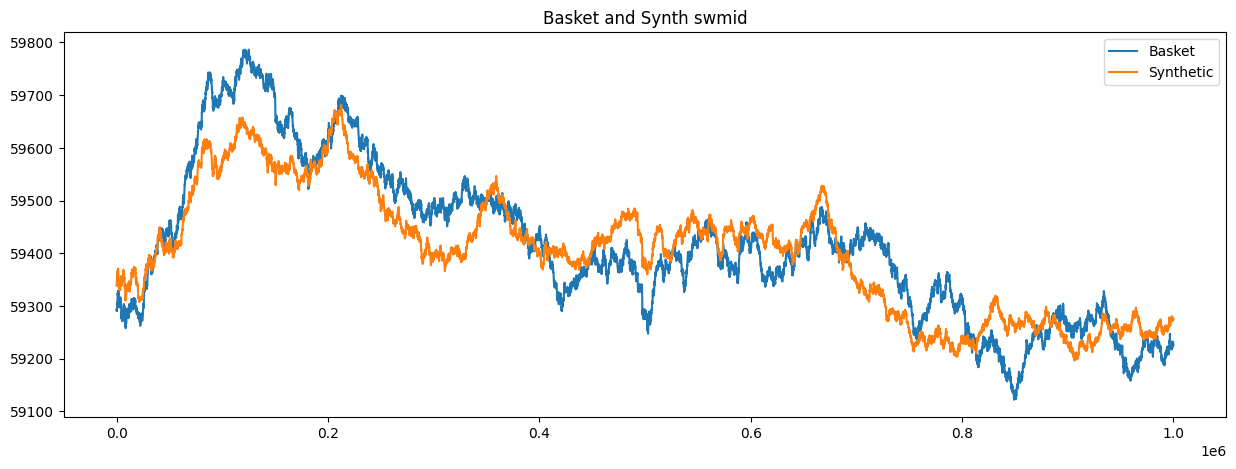

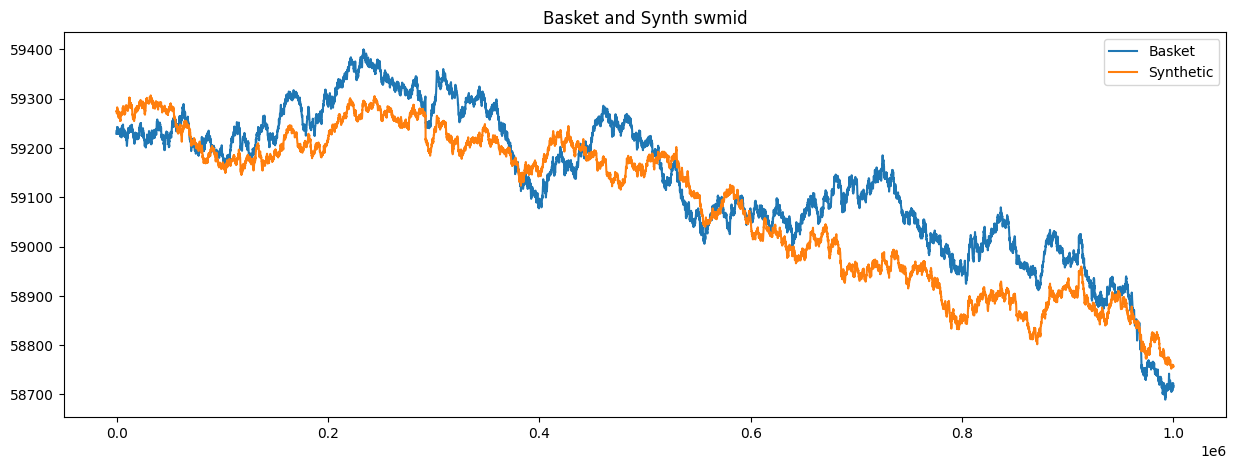

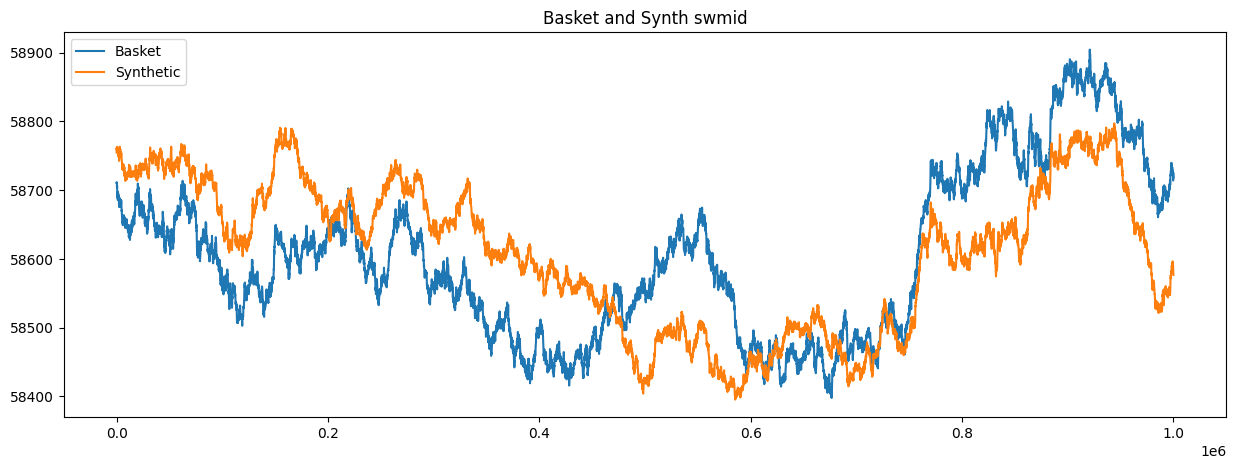

In [24]:
for day in [-1, 0, 1]:
    q = mk['day'] == day
    mkq = mk[q]

    plt.figure(figsize=(15, 5))
    plt.title('Basket and Synth swmid')
    plt.plot(mkq['timestamp'], mkq['swmid_basket1'], label='Basket')
    plt.plot(mkq['timestamp'], mkq['swmid_synth3'], label='Synthetic')
    plt.legend()
    plt.show()

basket is almost always above, some kind of sticky price associated with basket. movements seem similar but they're often very out of sync

compared to last y

In [26]:
# mk['spread1'] = mk['swmid_basket1'] - mk['swmid_synth1']
# mk.groupby('day')['spread1'].describe()


mk['b1_s3_spread'] = mk['swmid_basket1'] - mk['swmid_synth3']
mk.groupby('day')['b1_s3_spread'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
-1,10000.0,11.963393,65.660621,-146.694838,-39.860788,8.126541,64.468781,168.944444
0,10000.0,47.781266,63.231961,-96.094686,4.384151,54.859748,92.462005,208.071429
1,10000.0,-4.112082,98.243357,-196.706897,-88.781515,-19.954685,89.563709,199.308610


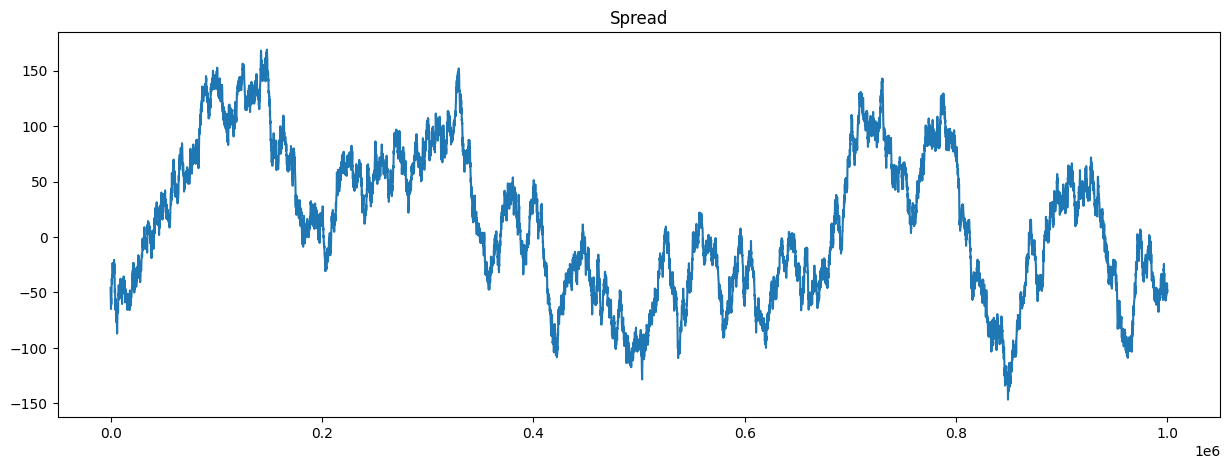

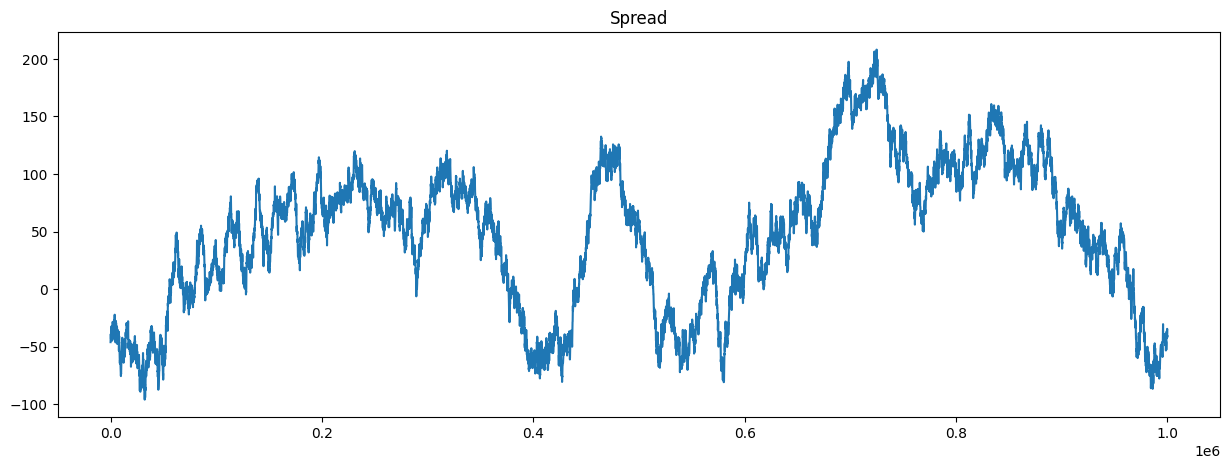

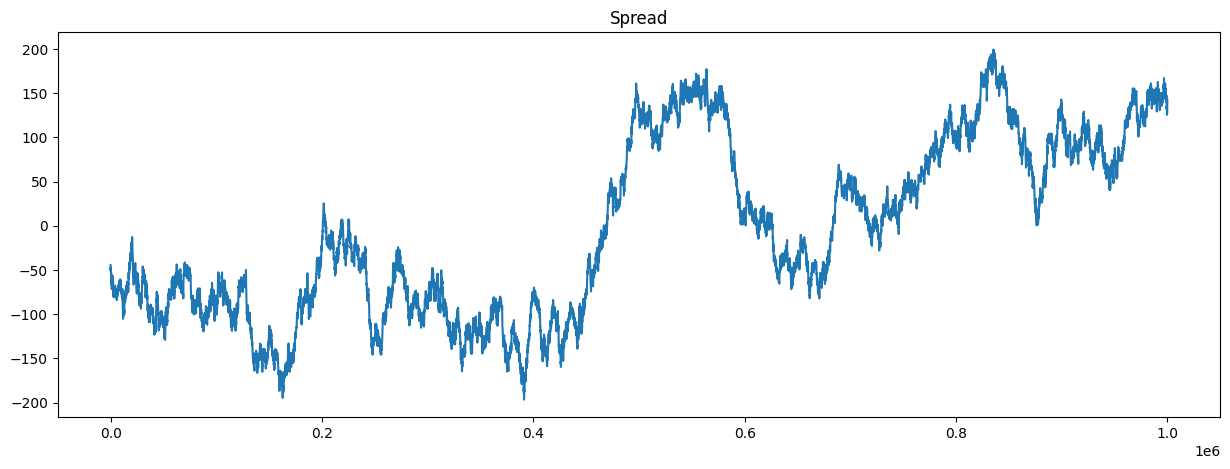

In [27]:
for day in [-1, 0, 1]:
    q = mk['day'] == day
    mkq = mk[q]

    plt.figure(figsize=(15, 5))
    plt.title('Spread')
    plt.plot(mkq['timestamp'], mkq['b1_s3_spread'])
    plt.show()

theoretically, mean should be around 0 but instead hovers in some positive direction, inconsistent across days

In [113]:
mk['mid_price_spread1'] =  mk['mid_price_basket1'] - mk['mid_price_synth1']
mk['mid_price_spread2'] = mk['mid_price_basket2'] - mk['mid_price_synth2']

mk['swmid_price_spread1'] = mk['swmid_basket1'] - mk['swmid_price_synth1']
mk['swmid_price_spread2'] = mk['swmid_basket2'] - mk['swmid_price_synth2']

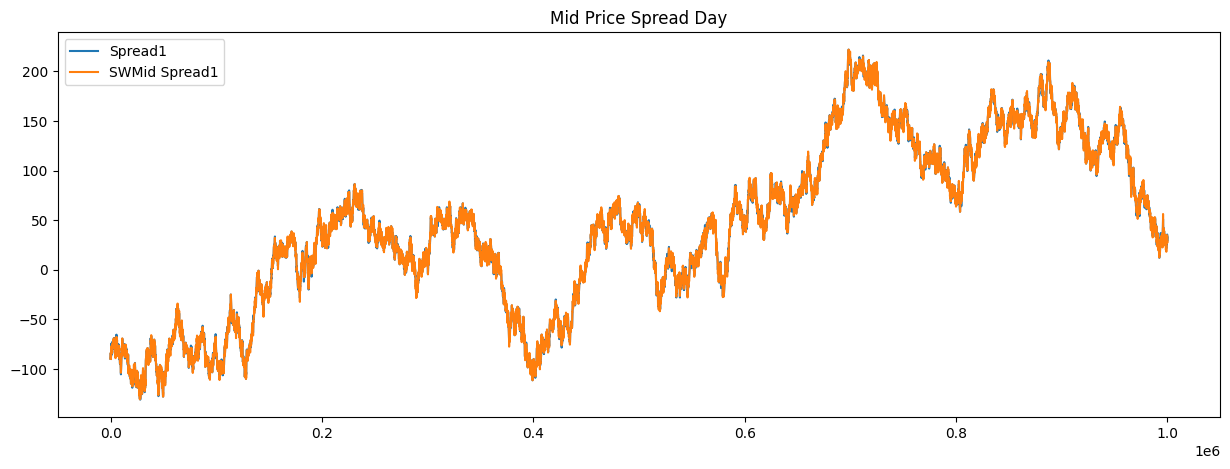

In [115]:
plt.figure(figsize=(15, 5))
plt.title('Mid Price Spread Day')
plt.plot(mk['timestamp'], mk['mid_price_spread1'], label='Spread1')
plt.plot(mk['timestamp'], mk['swmid_price_spread1'], label='SWMid Spread1')
plt.legend()
plt.show()

In [72]:
mk['mid_price_spread1'].describe()

count    30000.000000
mean        48.762433
std         85.119451
min       -194.500000
25%         -5.000000
50%         51.000000
75%        112.500000
max        251.000000
Name: mid_price_spread1, dtype: float64

In [73]:
mk['mid_price_spread2'].describe()

count    30000.000000
mean        30.235967
std         59.849200
min       -120.500000
25%        -22.000000
50%         38.500000
75%         75.000000
max        149.500000
Name: mid_price_spread2, dtype: float64

In [116]:
mk['spread1_sma'] = mk['swmid_price_spread1'].rolling(window=300).mean()
mk['spread1_std'] = mk['swmid_price_spread1'].rolling(window=50).std()
mk['spread1_zscore'] = (mk['swmid_price_spread1'] - mk['spread1_sma']) / mk['spread1_std']

In [132]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=mk['timestamp'], y=mk['swmid_price_spread1'], mode='lines', name='SWMid Spread1'))
fig.add_trace(go.Scatter(x=mk['timestamp'], y=mk['spread1_sma'], mode='lines', name='Spread1 SMA'))
fig.add_trace(go.Scatter(x=mk['timestamp'], y=mk['spread1_zscore'], mode='lines', name='Spread1 Z-Score', yaxis='y2'))

fig.update_layout(yaxis2=dict(title='Z Score', overlaying='y', side='right'))
fig.update_layout(title='Spread1 Z-Score', xaxis_title='Timestamp', yaxis_title='Z-Score')
fig.show()

In [151]:
spread = mk[['timestamp', 'swmid_price_spread1']].copy()
spread.rename(columns={'swmid_price_spread1': 'swmid'}, inplace=True)
spread['spread'] = spread['swmid'].copy()

spread2 = mk[['timestamp', 'swmid_price_spread2']].copy()
spread2.rename(columns={'swmid_price_spread2': 'swmid'}, inplace=True)
spread2['spread'] = spread2['swmid'].copy()

In [152]:
from tqdm import tqdm

def cross_spread(cash, quantity):
    return cash - abs(quantity) * 10

def backtest(spread, thresh, target_position, std_window, sma_window, verbose=False):
    cash = 0
    position = 0
    pnl_hist = []
    position_hist = []
    cash_hist = []
    spread[f'std{std_window}'] = spread['spread'].rolling(window=std_window).std()
    spread[f'sma{sma_window}'] = spread['spread'].rolling(window=sma_window).mean()
    z_score = (spread['spread'].to_numpy() - spread[f'sma{sma_window}']) / spread[f'std{std_window}'].to_numpy()
    spread['spread_z'] = z_score
    for index, row in spread.iterrows():
        if index == 0:
            continue
        swmid = row['swmid']
        
        if row['spread_z'] > thresh and position != -target_position:
        
            
            quantity = -target_position - position
            cash -= (-target_position - position) * swmid
            cash = cross_spread(cash, quantity)
            position = -target_position
            
            if verbose:
                print(f"SELL {quantity} AT PRICE {swmid} AT TIME {row['timestamp']}")
        
        if row['spread_z'] < -thresh and position != target_position:
            quantity = target_position - position
            cash -= (target_position - position) * swmid
            cash = cross_spread(cash, quantity)
            position = target_position
            
            if verbose:
                print(f"BUY {quantity} FOR PRICE {swmid} AT TIME {row['timestamp']}")
    
        position_hist.append(position)
        cash_hist.append(cash)
        pnl_hist.append(cash + position * swmid)
        
    if verbose:
        print(f"PNL: {pnl_hist[-1]}")
        
    return pnl_hist


In [163]:
position_opt = [60]
thresh_opt = [1,2,3,5,6,7,7.5,8,9,10,15,20,25]
std_window_opt = [10,20,25,30,35,40,50]
sma_window_opt = [10,20,25,30,35,40,50,75, 100, 125, 150, 200, 300, 500]
opt = []
for thresh in tqdm(thresh_opt): 
    for std_window in std_window_opt: 
        for sma_window in sma_window_opt:
            for position in position_opt:
                pnl = backtest(spread2, thresh, position, std_window, sma_window)
                opt.append({"thresh": thresh, "position": position, "std_window": std_window, "sma_window": sma_window, "pnl": pnl})
#                 print("="*80)
#                 print(f"Thresh: {thresh}, Position: {position}, Std Window: {std_window}, PnL: {pnl[-1]}")
#                 print("="*80)

100%|██████████| 13/13 [02:55<00:00, 13.46s/it]


In [164]:
spread['spread'].mean()

np.float64(43.922489021349016)

In [165]:
opt.sort(key=lambda x: x['pnl'][-1], reverse=True)
top_3_pnl = opt[:3]
pnl_graph = top_3_pnl[0]['pnl']

fig = go.Figure()
fig.add_trace(go.Scatter(x=spread.index, y=pnl_graph, mode='lines', name='PnL'))
fig.show()

In [167]:
top_3_pnl = opt[:3]
top_pnl_params = top_3_pnl[0]
for params in top_3_pnl:
    print(f"thresh: {params['thresh']}, std_window: {params['std_window']}, sma_window: {params['sma_window']}, pnl: {params['pnl'][-1]}")

thresh: 8, std_window: 25, sma_window: 125, pnl: 12486.761331593298
thresh: 10, std_window: 25, sma_window: 150, pnl: 11953.98168192296
thresh: 5, std_window: 20, sma_window: 35, pnl: 10530.0


spread1
thresh: 7, std_window: 35, sma_window: 125, pnl: 24212.82352941198
thresh: 7, std_window: 50, sma_window: 200, pnl: 21864.714339038765
thresh: 5, std_window: 50, sma_window: 125, pnl: 21512.814052237227

spread2
thresh: 8, std_window: 25, sma_window: 125, pnl: 12486.761331593298
thresh: 10, std_window: 25, sma_window: 150, pnl: 11953.98168192296
thresh: 5, std_window: 20, sma_window: 35, pnl: 10530.0

In [166]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=spread.index, y=pnl_graph, mode='lines', name='PnL'))
# fig.show()

for o in opt[:5]:
    # graph the pnl
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=spread.index, y=o['pnl'], mode='lines', name='PnL'))
    fig.update_layout(title=f"Thresh: {o['thresh']}, Position: {o['position']}, Std Window: {o['std_window']}, Sma Window: {o['sma_window']}, PnL: {o['pnl'][-1]}")
    fig.show()
    